# Humpback whales

<img src="https://www.marinemammalcenter.org/storage/app/uploads/public/3ad/5b0/309/thumb__1600_0_0_0_crop.jpg" alt="humpback whale" width="50%"/>

&copy; Marine Mammal Center

Recordings from:

Monterey Bay Aquarium Research Institute (2018). *Free Sound*. [https://www.freesound.org/people/MBARI_MARS/sounds/403406/](https://www.freesound.org/people/MBARI_MARS/sounds/403406/)

## Setup

In [1]:
# import packages
import chatter
from pathlib import Path

In [2]:
# set config parameters that depart from defaults
config = {
    # spectrogram parameters
    "fmin": 0,
    "fmax": 5000,
    # preprocessing parameters
    "use_biodenoising": True,
    "use_noisereduce": True,
    "static": False,
    "target_dbfs": -20,
    "compressor_amount": -20,
    "limiter_amount": -10,
    # simple segmentation parameters
    "simple_noise_floor": -60,
    "simple_silence_threshold_db": -60,
    "simple_min_silence_length": 0.1,
    "simple_max_unit_length": 3.5,
    "simple_min_unit_length": 0.2,
    # other parameters
    "plot_clip_duration": 40,
}
config = chatter.make_config(config)

# initialize the analyzer with the configuration
# using only 8 cores to avoid memory crash during segmentation
analyzer = chatter.Analyzer(config, n_jobs=8)
model = chatter.Trainer(config)

# set paths
input_dir = Path(
    "/Volumes/Expansion/data/chatter/examples/humpback_whale/recordings/mbari_mars"
)
processed_dir = Path(
    "/Volumes/Expansion/data/chatter/examples/humpback_whale/recordings/processed"
)
h5_path = Path(
    "/Volumes/Expansion/data/chatter/examples/humpback_whale/spectrograms.h5"
)
csv_path = Path(
    "/Volumes/Expansion/data/chatter/examples/humpback_whale/spectrograms.csv"
)
model_dir = Path("/Volumes/Expansion/data/chatter/examples/humpback_whale/model")
output_csv_path = Path(
    "/Volumes/Expansion/data/chatter/examples/humpback_whale/output.csv"
)

Using 8 cores for parallel processing
Initializing convolutional variational autoencoder
Using device: mps


## Preprocessing

--- Demoing preprocessing for: 403406__mbari_mars__humpback-whale.wav ---
   Segment: 104.45s - 144.45s


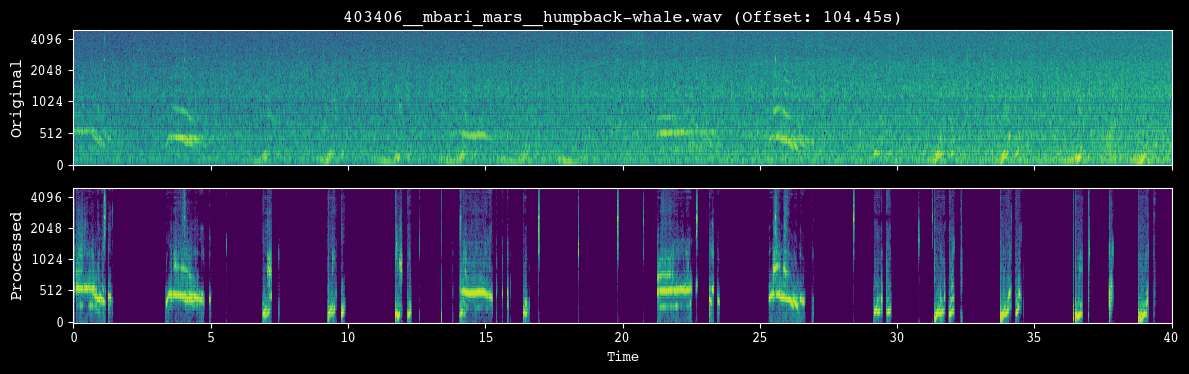

In [8]:
# demo the preprocessing pipeline
analyzer.demo_preprocessing(input_dir)

In [3]:
# preprocess recordings
analyzer.preprocess_directory(input_dir=input_dir, processed_dir=processed_dir)

--- Found 1 audio files to preprocess ---


Preprocessing audio: 100%|██████████| 1/1 [02:14<00:00, 134.57s/it]


--- Preprocessing complete. Standardized WAV audio saved to /Volumes/Expansion/data/chatter/examples/humpback_whale/recordings/processed ---


## Segmentation

--- Demoing segmentation for: 403406__mbari_mars__humpback-whale.wav ---
   Segment: 1968.03s - 2008.03s


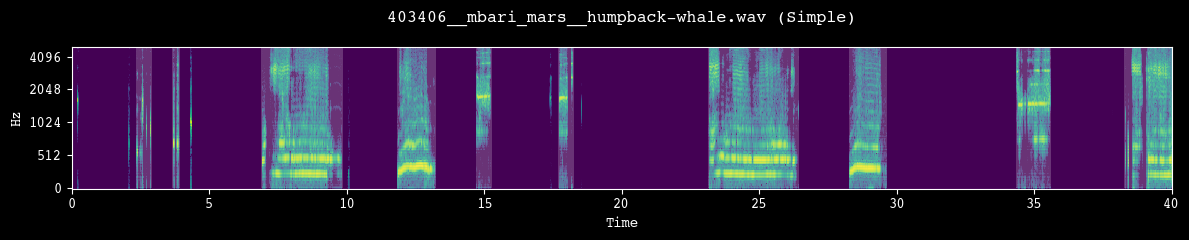

--- Demoing segmentation for: 403406__mbari_mars__humpback-whale.wav ---
   Segment: 2029.44s - 2069.44s


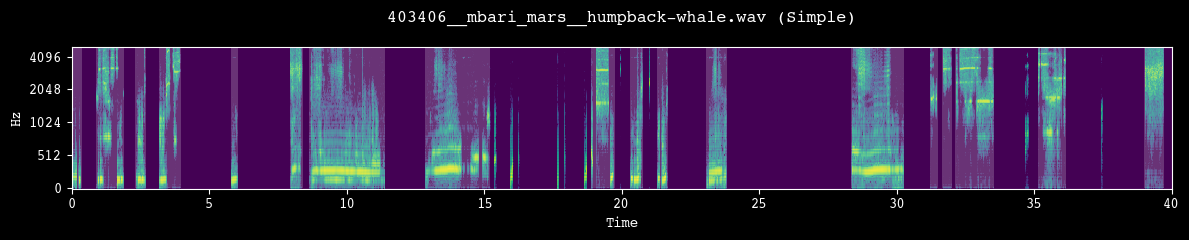

--- Demoing segmentation for: 403406__mbari_mars__humpback-whale.wav ---
   Segment: 6498.21s - 6538.21s


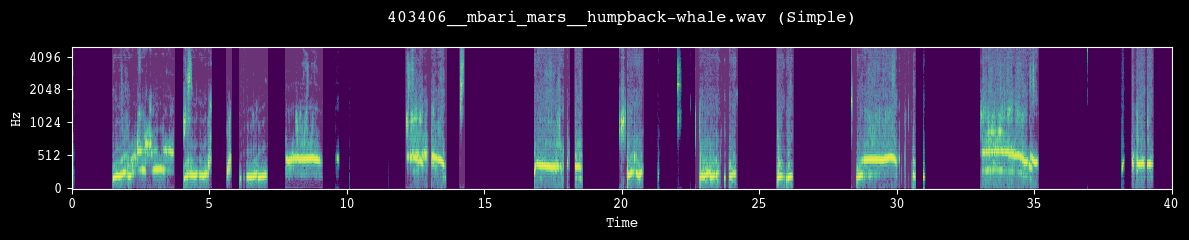

--- Demoing segmentation for: 403406__mbari_mars__humpback-whale.wav ---
   Segment: 3775.94s - 3815.94s


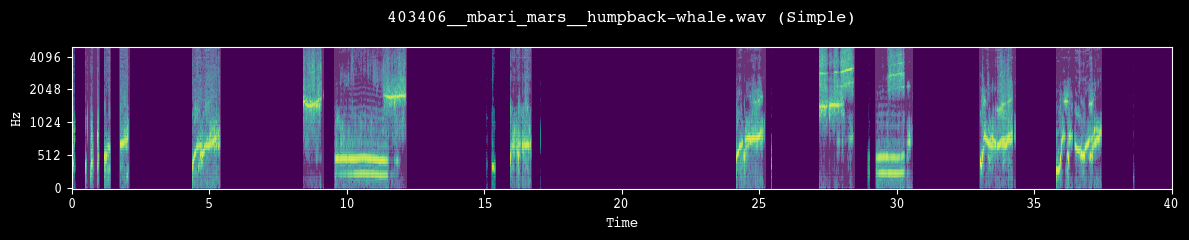

In [12]:
# preview the segmentation pipeline
analyzer.demo_segmentation(input_dir=processed_dir, simple=True)
analyzer.demo_segmentation(input_dir=processed_dir, simple=True)
analyzer.demo_segmentation(input_dir=processed_dir, simple=True)
analyzer.demo_segmentation(input_dir=processed_dir, simple=True)

In [4]:
# segment units and save spectrograms
unit_df = analyzer.segment_and_create_spectrograms(
    processed_dir=processed_dir, h5_path=h5_path, csv_path=csv_path, simple=True
)


--- Found 1 files to segment using simple (amplitude-based) method ---


Segmenting and saving spectrograms: 100%|██████████| 1/1 [00:34<00:00, 34.22s/it]



--- Data preparation complete. Created records for 2689 units ---
Spectrograms saved to /Volumes/Expansion/data/chatter/examples/humpback_whale/spectrograms.h5
Unit metadata saved to /Volumes/Expansion/data/chatter/examples/humpback_whale/spectrograms.csv


## Run model

In [5]:
# load segmented units
unit_df = analyzer.load_df(csv_path)

Attempting to load /Volumes/Expansion/data/chatter/examples/humpback_whale/spectrograms.csv...
--- Successfully loaded /Volumes/Expansion/data/chatter/examples/humpback_whale/spectrograms.csv ---


In [6]:
# train ae
model.train_ae(unit_df=unit_df, h5_path=h5_path, model_dir=model_dir, subset=0.5)

--- Training on a random subset of 1344 units (50.0%) ---

Starting training for 100 epochs using 4 DataLoader workers...


Training model: 100%|██████████| 100/100 [04:53<00:00,  2.94s/it, loss=686.5163]


--- Training complete. Model saved to /Volumes/Expansion/data/chatter/examples/humpback_whale/model/model.pth ---
Loss history saved to /Volumes/Expansion/data/chatter/examples/humpback_whale/model/loss.csv


In [7]:
# load trained vae
model = chatter.Trainer.from_trained(config, model_dir)

Instantiating Trainer from pre-trained model at /Volumes/Expansion/data/chatter/examples/humpback_whale/model...
Initializing convolutional variational autoencoder
Using device: mps
Successfully loaded pre-trained model from /Volumes/Expansion/data/chatter/examples/humpback_whale/model/model.pth


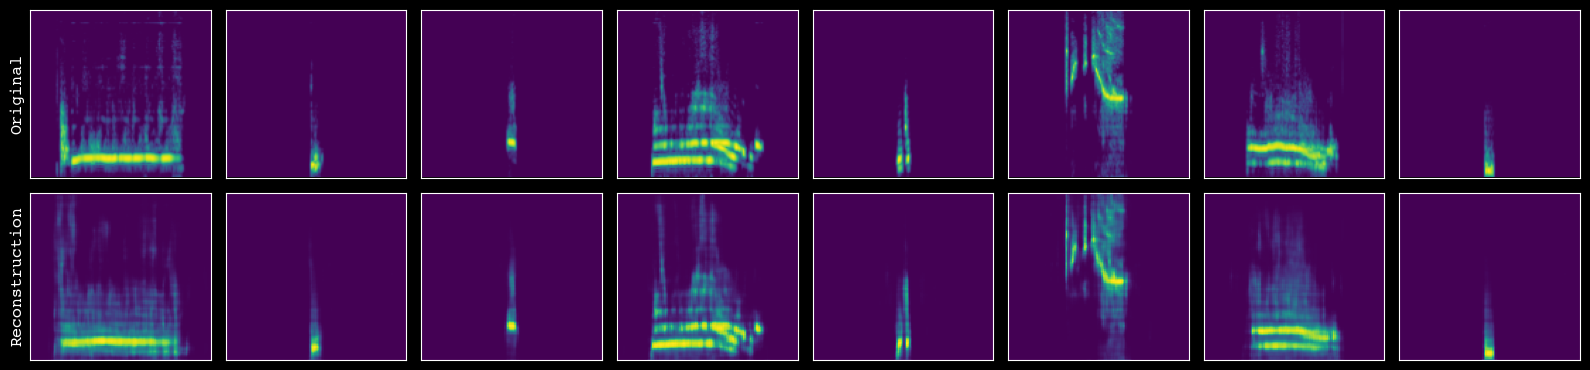

In [8]:
# assess the quality of reconstruction
model.plot_reconstructions(unit_df=unit_df, h5_path=h5_path)

In [9]:
# export the latent features
output = model.extract_and_save_features(
    unit_df=unit_df,
    h5_path=h5_path,
    model_dir=model_dir,
    output_csv_path=output_csv_path,
)


--- Starting feature extraction ---
Successfully loaded pre-trained model from /Volumes/Expansion/data/chatter/examples/humpback_whale/model/model.pth


Extracting features: 100%|██████████| 43/43 [00:06<00:00,  7.00it/s]



--- Pipeline complete. Exported data for 2689 units to /Volumes/Expansion/data/chatter/examples/humpback_whale/output.csv ---


## Postprocessing

In [10]:
# load in latent features
output = chatter.FeatureProcessor(analyzer.load_df(output_csv_path), config)

Attempting to load /Volumes/Expansion/data/chatter/examples/humpback_whale/output.csv...
--- Successfully loaded /Volumes/Expansion/data/chatter/examples/humpback_whale/output.csv ---


In [11]:
# process output and save
output.run_pacmap()
output.df.to_csv(output_csv_path, index=False)

--- Running PaCMAP dimensionality reduction ---
--- PaCMAP complete ---


--- Automatically selecting focal points from quadrants with seed 11111 ---
--- Finding nearest neighbors ---
--- Creating the plot ---
--- Plotting density background (using fast 2d histogram) ---
--- Calculating callout positions and adding spectrograms ---
--- Displaying plot ---


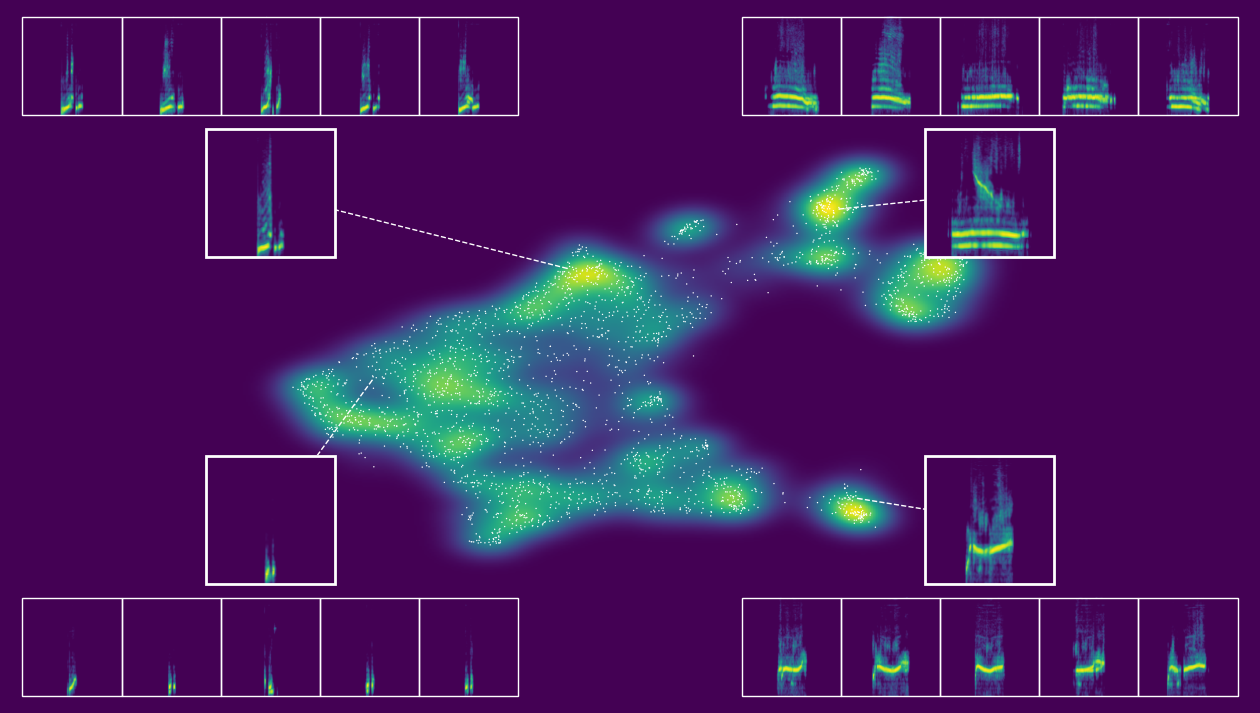

In [17]:
# create interactive or static plot
output.static_embedding_plot(
    h5_path=h5_path,
    seed=11111,
    focal_quantile=0.5,
    point_size=1,
    point_alpha=1,
    margin=0.01,
    zoom_padding=0.42,
    num_neighbors=5,
)